<a href="https://colab.research.google.com/github/khoji-code/Data-Analysis/blob/main/E_commerce_Conversion_Prediction_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-commerce Conversion Prediction with Machine Learning

### **Project Overview**

* **Goal:** To develop a machine learning model that can accurately predict whether an online shopping session will result in a purchase (`Revenue`).
* **Dataset:** Utilizes the "Online Shoppers Purchasing Intention" dataset from the UCI Machine Learning Repository, which captures various user session metrics.
* **Methodology:** The project involves exploratory data analysis (EDA) to understand user behavior, followed by a robust preprocessing pipeline to handle both numerical and categorical features. A high-performance LightGBM classifier is trained, with a key focus on addressing the significant class imbalance between purchase and non-purchase sessions using `scale_pos_weight`.
* **Key Results:** The model demonstrates strong predictive power, achieving an accuracy of **89%** and a ROC AUC score of **0.905**.

***

### **Purpose**

* **Predict Purchase Intent:** To create a reliable model that can predict in real-time if a user is likely to make a purchase based on their browsing behavior.
* **Improve Conversion Rates:** To provide e-commerce businesses with actionable insights to optimize their websites and marketing strategies, such as offering targeted promotions to users who are less likely to convert.
* **Understand Customer Behavior:** To identify the key metrics and user actions (like `PageValues` and `ExitRates`) that are most indicative of purchasing intent, helping to improve the overall user experience.

### Dataset:
https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

## IMPORT LIBRARIES

In [1]:
# Install LIGHTGBM
!pip install -q lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score
import lightgbm as lgb
import warnings

# Explain: Ignore warnings for a cleaner output.
warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


## LOAD AND PREPARE DATA

In [2]:
try:
    df = pd.read_csv('/content/drive/MyDrive/Online Shop/online_shoppers_intention.csv')
    print("Dataset loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    print("Error: 'online_shoppers_intention.csv' not found. Please upload the file to your Colab session.")
    exit()


Dataset loaded successfully. Shape: (12330, 18)


### Initial Data Inspection

In [3]:
print("\nData Head:")
print(df.head())
print("\nData Info:")
df.info()


Data Head:
   Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         

## EXPLORATORY DATA ANALYSIS (EDA)

### Target Variable Distribution (Revenue)

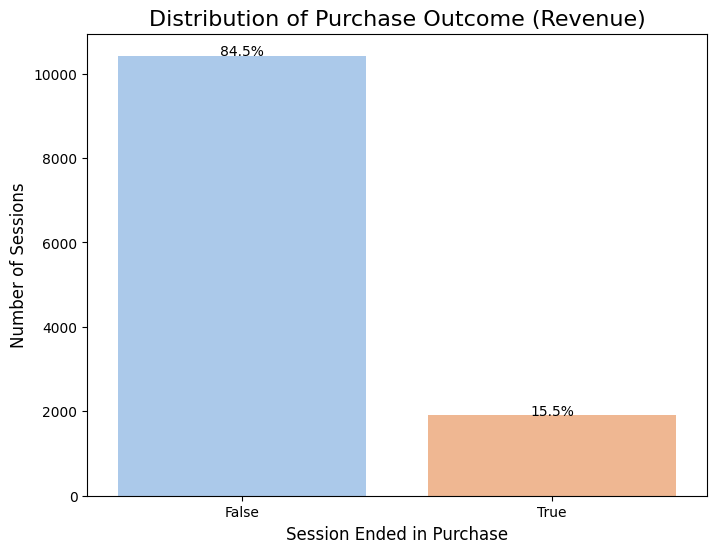

In [4]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Revenue', data=df, palette='pastel')
plt.title('Distribution of Purchase Outcome (Revenue)', fontsize=16)
plt.xlabel('Session Ended in Purchase', fontsize=12)
plt.ylabel('Number of Sessions', fontsize=12)
# Calculate and display percentages
total = len(df)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5, f'{height/total:.1%}', ha='center')
plt.show()

### Purchase Rate by Visitor Type

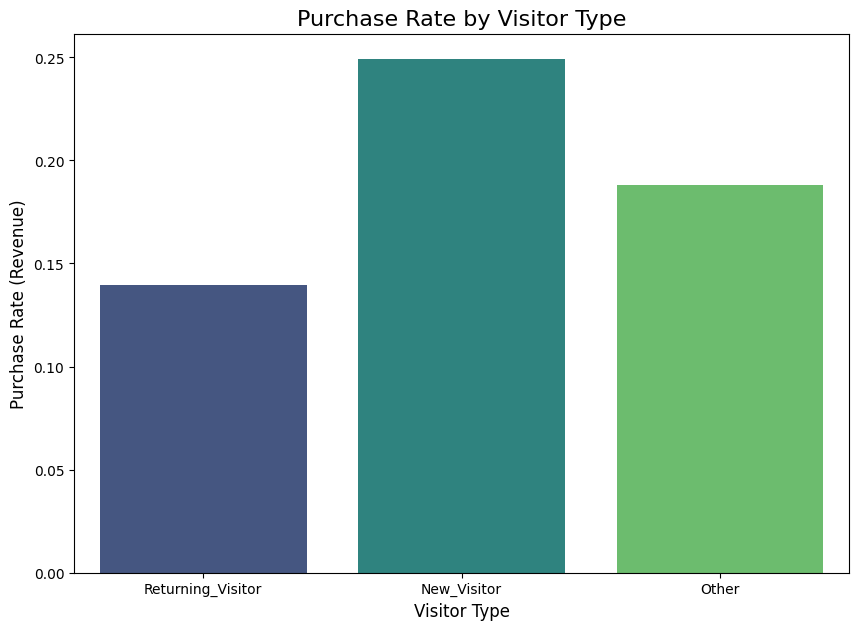

In [5]:
plt.figure(figsize=(10, 7))
sns.barplot(x='VisitorType', y='Revenue', data=df, palette='viridis', ci=None)
plt.title('Purchase Rate by Visitor Type', fontsize=16)
plt.xlabel('Visitor Type', fontsize=12)
plt.ylabel('Purchase Rate (Revenue)', fontsize=12)
plt.show()

### PageValues vs. Revenue

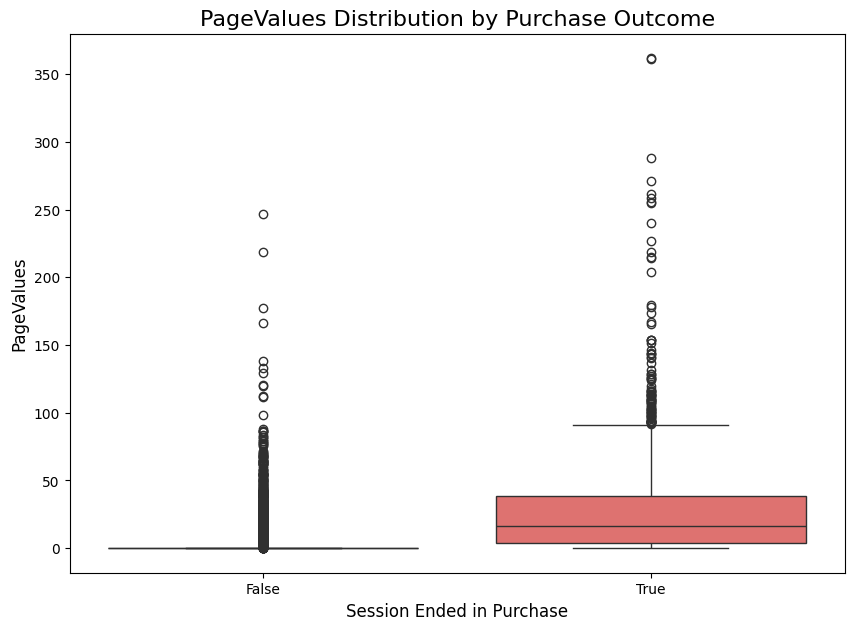

In [7]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Revenue', y='PageValues', data=df, palette='magma')
plt.title('PageValues Distribution by Purchase Outcome', fontsize=16)
plt.xlabel('Session Ended in Purchase', fontsize=12)
plt.ylabel('PageValues', fontsize=12)
plt.show()

## DATA PREPROCESSING

### Feature and Target Separation

In [9]:
X = df.drop('Revenue', axis=1)
y = df['Revenue']

### Manual Encoding of Binary and Ordinal Features

In [10]:
# Manually handle simple encodings
month_map = {
    'Feb': 2, 'Mar': 3, 'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
X['Month'] = X['Month'].map(month_map)
X['Weekend'] = X['Weekend'].astype(int)

## Target Variable Encoding

In [11]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("Target variable encoded successfully.")

Target variable encoded successfully.


### Identify Column Types for Pipeline

In [12]:
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")


Numerical columns (16): ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend']
Categorical columns (1): ['VisitorType']


### Create Preprocessing Pipelines

In [13]:
# `numerical_transformer`: Applies StandardScaler to all numerical columns
# `categorical_transformer`: Applies OneHotEncoder to the remaining categorical columns ('VisitorType')
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine Pipelines with ColumnTransformer
# `ColumnTransformer` applies our defined transformers to the correct columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

## MODEL TRAINING

In [14]:
# `stratify=y_encoded` is crucial for imbalanced datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Handle Class Imbalance
# Weight for the minority class (purchases) -  This weight, `scale_pos_weight`
# LightGBM model to pay much more attention to purchase samples
neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
scale_pos_weight_value = neg_count / pos_count
print(f"Scale Position Weight calculated: {scale_pos_weight_value:.2f}")


Scale Position Weight calculated: 5.46


### Create the Full Model Pipeline

In [16]:
# LightGBM Parameters:
# - objective='binary': Specifies binary classification.
# - scale_pos_weight: Our calculated weight to handle imbalance.
# - n_estimators: Number of trees to build.
# - learning_rate: Controls the step size at each iteration.
# - num_leaves: Controls the complexity of the model.
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(
        objective='binary',
        scale_pos_weight=scale_pos_weight_value,
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42
    ))
])

# Train
model_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1526, number of negative: 8338
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1901
[LightGBM] [Info] Number of data points in the train set: 9864, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154704 -> initscore=-1.698173
[LightGBM] [Info] Start training from score -1.698173


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Administrative',
                                                   'Administrative_Duration',
                                                   'Informational',
                                                   'Informational_Duration',
                                                   'ProductRelated',
                                                   'ProductRelated_Duration',
                                                   'BounceRates', 'ExitRates',
                                                   'PageValues', 'SpecialDay',
                                                   'Month', 'OperatingSystems',
                                                   'Browser', 'Region',
                                                   'TrafficType', 'Weekend']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VisitorType'])])),
                ('classifier',
                 LGBMClassifier(learning_rate=0.05, n_estimators=1000,
                                objective='binary', random_state=42,
                                scale_pos_weight=np.float64(5.463958060288335)))])

## MODEL EVALUATION

In [17]:
# Make Prediction
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probabilities for the positive class

# Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f} (Note: Not a reliable metric for imbalanced data)")
print(f"Model F1-Score: {f1:.4f} (A better metric, balancing precision and recall)")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Purchase', 'Purchase']))

Model Accuracy: 0.8889 (Note: Not a reliable metric for imbalanced data)
Model F1-Score: 0.6532 (A better metric, balancing precision and recall)

Classification Report:
              precision    recall  f1-score   support

 No Purchase       0.94      0.93      0.93      2084
    Purchase       0.63      0.68      0.65       382

    accuracy                           0.89      2466
   macro avg       0.79      0.80      0.79      2466
weighted avg       0.89      0.89      0.89      2466



### Confusion Matrix

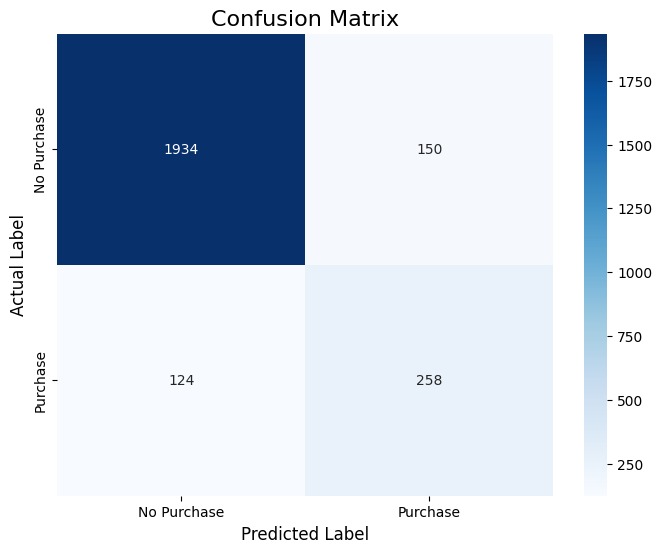

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Purchase', 'Purchase'],
            yticklabels=['No Purchase', 'Purchase'])
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

### ROC Curve and AUC Score

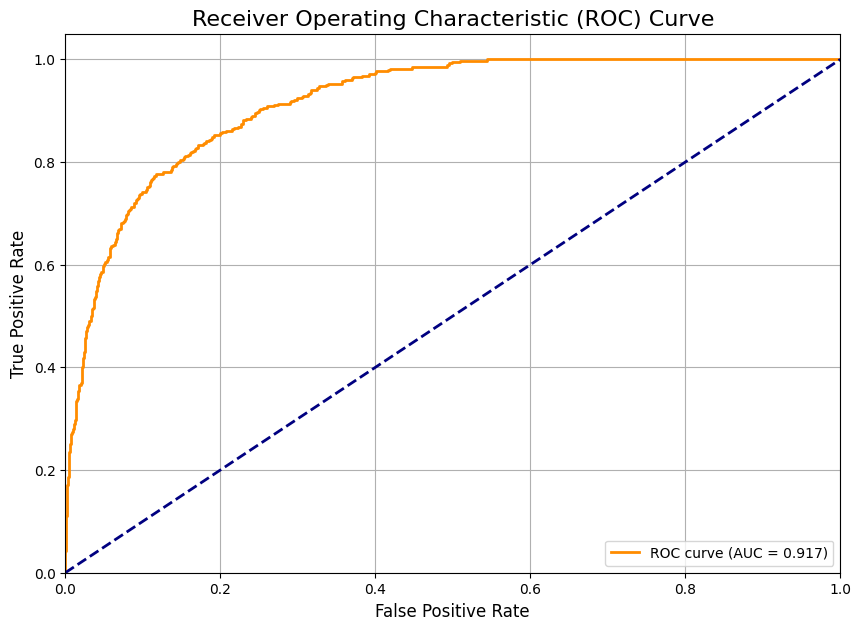

In [20]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()